# Computing Similarity based on MinHash Signatures

This notebook goes through all our internal Shingle and MinHash utility functions and explains the reasoning for some final project choices.

In [1]:
import os
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt
from loguru import logger
import numpy as np

In [3]:
from utils.load import load_sequences
from utils.shingles import generate_shingles
from utils.hash import compute_minhash
from utils.hash import pairwise_minhash_similarity

Let's verify that we are computing similarities correctly.

In [4]:
def verify_minhash():

    sequences_df = load_sequences("data/sequences")[:1]
    logger.info(f"Sequences sample:\n{sequences_df.head()}")

    # take first sequence
    s = sequences_df.iloc[0]['sequence']

    # compute MinHash signatures
    sig1 = compute_minhash(generate_shingles(s))
    sig2 = compute_minhash(generate_shingles(s))
    
    print(np.all(sig1 == sig2))   # should be True

    # modify the sequence slightly
    s_mod = s.copy()
    for i in range(len(s_mod)//10):
        s_mod[i] = (s_mod[i] + 1) % 128
    sig3 = compute_minhash(generate_shingles(s_mod))
    similarity = np.mean(sig1 == sig3)
    print("Approx. Jaccard (MinHash):", similarity)

In [5]:
verify_minhash()

Loading sequences: 0it [00:00, ?it/s]

Loading sequences: 91it [00:00, 2009.58it/s]
2025-11-10 23:24:05.445 | SUCCESS  | utils.load:load_sequences:80 - Loaded 91 sequences from data/sequences
2025-11-10 23:24:05.449 | INFO     | __main__:verify_minhash:4 - Sequences sample:
                  id                                           sequence  \
id                                                                        
tt0026138  tt0026138  [36, 51, 81, 55, 75, 74, 62, 60, 62, 75, 72, 6...   

                                       path  
id                                           
tt0026138  data/sequences/tt0026138_seq.npy  


True
Approx. Jaccard (MinHash): 0.92


Looks fine. Now let's compare the different methods.

In [6]:
# helpers to transform sequences prior to shingling

def to_intervals(sequence):
    seq = np.array(sequence)
    return np.diff(seq)

def pitch_class_normalization(sequence):
    seq = np.array(sequence)
    return [p % 12 for p in seq if p != 128] 


In [7]:
def test_minhash(
    shingle_size: int = 5,
    num_minhash: int = 100
):

    sequences_df = load_sequences("data/sequences") 
    logger.info(f"Sequences sample:\n{sequences_df.head()}")
    
    minhash_sigs_sequences = []
    minhash_sigs_intervals = []
    minhash_sigs_pitch_classes = []
    
    for _, row in sequences_df.iterrows():
        
        sequence = row['sequence']
        intervals = to_intervals(sequence)
        pitch_classes = pitch_class_normalization(intervals)

        shingles_sequences = generate_shingles(sequence, shingle_size=shingle_size)
        shingles_intervals = generate_shingles(intervals, shingle_size=shingle_size)
        shingles_pitch_classes = generate_shingles(pitch_classes, shingle_size=shingle_size)

        minhash_sequences = compute_minhash(shingles_sequences, k=num_minhash)
        minhash_intervals = compute_minhash(shingles_intervals, k=num_minhash)
        minhash_pitch_classes = compute_minhash(shingles_pitch_classes, k=num_minhash)

        minhash_sigs_sequences.append(minhash_sequences)
        minhash_sigs_intervals.append(minhash_intervals)
        minhash_sigs_pitch_classes.append(minhash_pitch_classes)

    
    minhash_sigs_sequences = np.array(minhash_sigs_sequences)
    minhash_sigs_intervals = np.array(minhash_sigs_intervals)
    minhash_sigs_pitch_classes = np.array(minhash_sigs_pitch_classes)

    logger.info(f"MinHash signatures shape: {minhash_sigs_sequences.shape}")
    logger.info(f"MinHash signatures shape: {minhash_sigs_intervals.shape}")
    logger.info(f"MinHash signatures shape: {minhash_sigs_pitch_classes.shape}")

    # Compute pairwise similarities
    similarity_matrix_sequences = pairwise_minhash_similarity(minhash_sigs_sequences)
    similarity_matrix_intervals = pairwise_minhash_similarity(minhash_sigs_intervals)
    similarity_matrix_pitch_classes = pairwise_minhash_similarity(minhash_sigs_pitch_classes)

    
    # sum similarities
    total_similarity_sequences = np.sum(similarity_matrix_sequences) - similarity_matrix_sequences.shape[0]  
    total_similarity_intervals = np.sum(similarity_matrix_intervals) - similarity_matrix_intervals.shape[0]
    total_similarity_pitch_classes = np.sum(similarity_matrix_pitch_classes) - similarity_matrix_pitch_classes.shape[0]

    logger.info(f"Total pairwise similarity (sequences): {total_similarity_sequences}")
    logger.info(f"Total pairwise similarity (intervals): {total_similarity_intervals}")
    logger.info(f"Total pairwise similarity (pitch classes): {total_similarity_pitch_classes}")

    for name, sim_matrix in [
        ("sequences", similarity_matrix_sequences),
        ("intervals", similarity_matrix_intervals),
        ("pitch_classes", similarity_matrix_pitch_classes)
    ]:
        plt.figure(figsize=(8, 6))
        plt.imshow(sim_matrix, cmap='viridis', interpolation='nearest')
        plt.title(f"Pairwise MinHash Similarity - {name}, shingle size={shingle_size}, num_min_hash={num_minhash}")
        plt.colorbar()
        plt.xlabel("Sequence Index")
        plt.ylabel("Sequence Index")
        plt.tight_layout()
        plt.show()

##### q = 5

Loading sequences: 91it [00:00, 6542.93it/s]
2025-11-10 23:24:05.509 | SUCCESS  | utils.load:load_sequences:80 - Loaded 91 sequences from data/sequences
2025-11-10 23:24:05.513 | INFO     | __main__:test_minhash:7 - Sequences sample:
                  id                                           sequence  \
id                                                                        
tt0026138  tt0026138  [36, 51, 81, 55, 75, 74, 62, 60, 62, 75, 72, 6...   
tt0029583  tt0029583  [60, 128, 69, 57, 53, 69, 53, 50, 60, 128, 69,...   
tt0032138  tt0032138  [39, 63, 70, 67, 63, 39, 46, 128, 51, 128, 55,...   
tt0040076  tt0040076  [55, 55, 55, 43, 57, 57, 57, 45, 55, 55, 55, 4...   
tt0045152  tt0045152  [41, 60, 53, 41, 81, 69, 77, 81, 128, 72, 69, ...   

                                       path  
id                                           
tt0026138  data/sequences/tt0026138_seq.npy  
tt0029583  data/sequences/tt0029583_seq.npy  
tt0032138  data/sequences/tt0032138_seq.npy  
tt0040076 

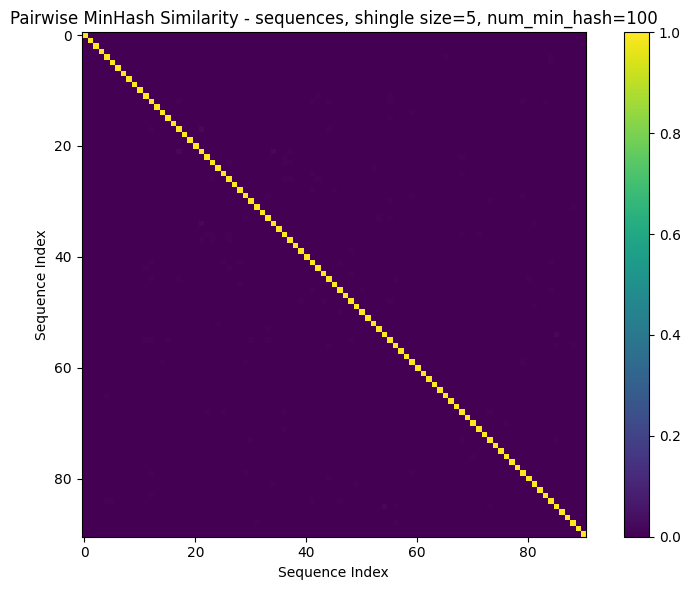

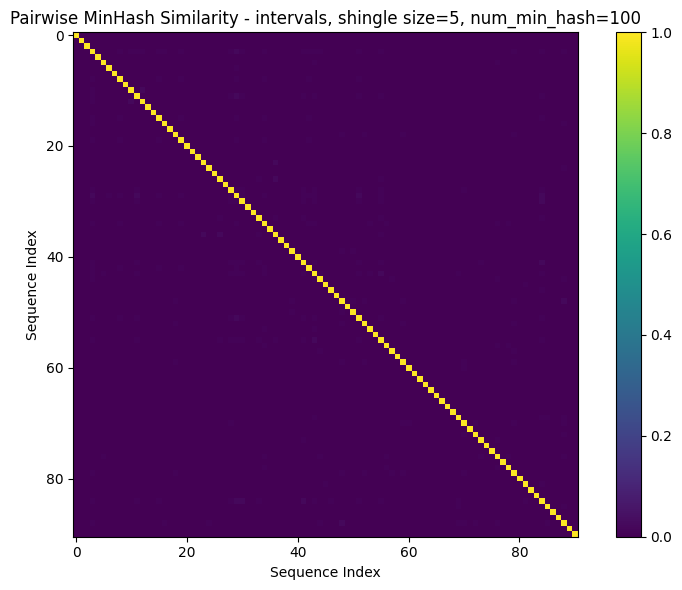

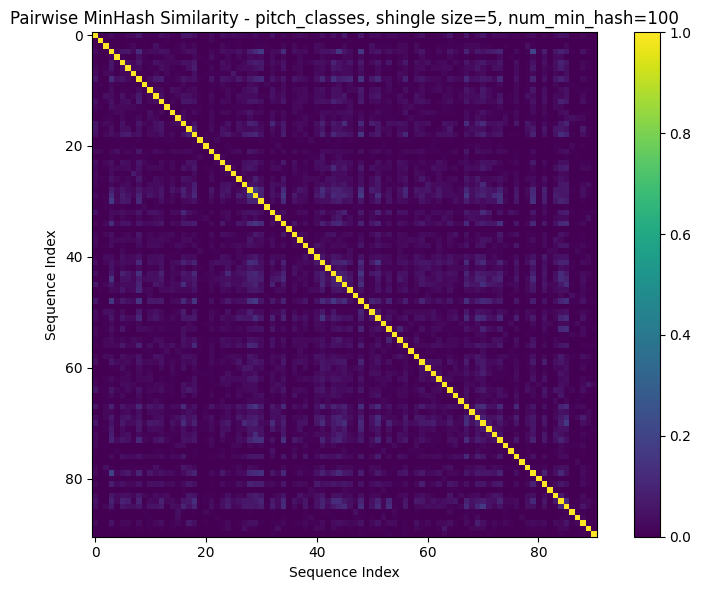

In [8]:
test_minhash(
    shingle_size=5,
    num_minhash=100
)

##### q = 4

Loading sequences: 91it [00:00, 9367.80it/s]
2025-11-10 23:24:10.933 | SUCCESS  | utils.load:load_sequences:80 - Loaded 91 sequences from data/sequences
2025-11-10 23:24:10.935 | INFO     | __main__:test_minhash:7 - Sequences sample:
                  id                                           sequence  \
id                                                                        
tt0026138  tt0026138  [36, 51, 81, 55, 75, 74, 62, 60, 62, 75, 72, 6...   
tt0029583  tt0029583  [60, 128, 69, 57, 53, 69, 53, 50, 60, 128, 69,...   
tt0032138  tt0032138  [39, 63, 70, 67, 63, 39, 46, 128, 51, 128, 55,...   
tt0040076  tt0040076  [55, 55, 55, 43, 57, 57, 57, 45, 55, 55, 55, 4...   
tt0045152  tt0045152  [41, 60, 53, 41, 81, 69, 77, 81, 128, 72, 69, ...   

                                       path  
id                                           
tt0026138  data/sequences/tt0026138_seq.npy  
tt0029583  data/sequences/tt0029583_seq.npy  
tt0032138  data/sequences/tt0032138_seq.npy  
tt0040076 

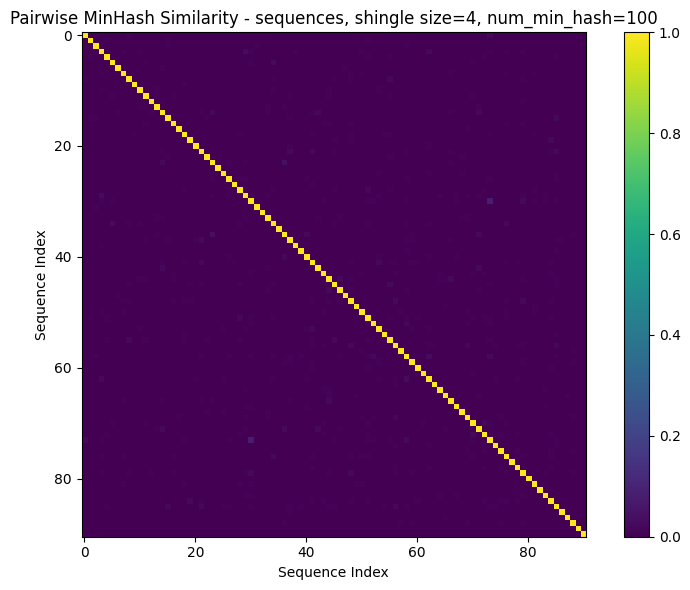

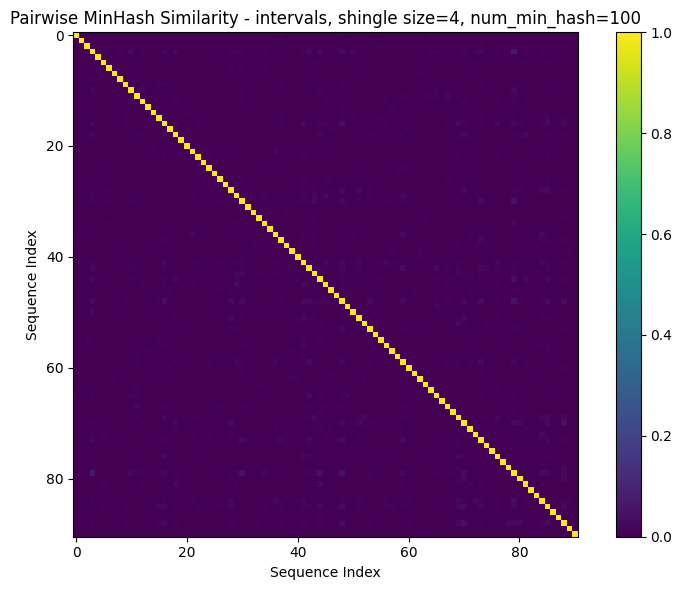

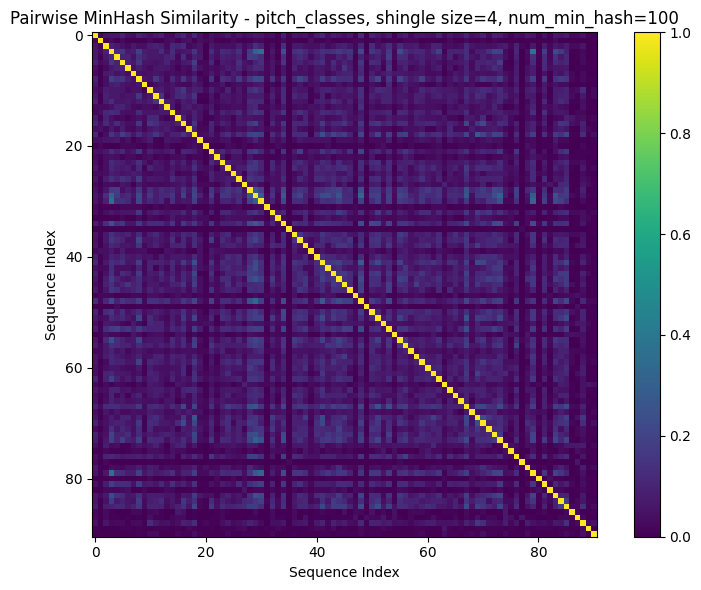

In [9]:
test_minhash(
    shingle_size=4,
    num_minhash=100
)

##### q = 3

Loading sequences: 91it [00:00, 9477.12it/s]
2025-11-10 23:24:16.207 | SUCCESS  | utils.load:load_sequences:80 - Loaded 91 sequences from data/sequences
2025-11-10 23:24:16.210 | INFO     | __main__:test_minhash:7 - Sequences sample:
                  id                                           sequence  \
id                                                                        
tt0026138  tt0026138  [36, 51, 81, 55, 75, 74, 62, 60, 62, 75, 72, 6...   
tt0029583  tt0029583  [60, 128, 69, 57, 53, 69, 53, 50, 60, 128, 69,...   
tt0032138  tt0032138  [39, 63, 70, 67, 63, 39, 46, 128, 51, 128, 55,...   
tt0040076  tt0040076  [55, 55, 55, 43, 57, 57, 57, 45, 55, 55, 55, 4...   
tt0045152  tt0045152  [41, 60, 53, 41, 81, 69, 77, 81, 128, 72, 69, ...   

                                       path  
id                                           
tt0026138  data/sequences/tt0026138_seq.npy  
tt0029583  data/sequences/tt0029583_seq.npy  
tt0032138  data/sequences/tt0032138_seq.npy  
tt0040076 

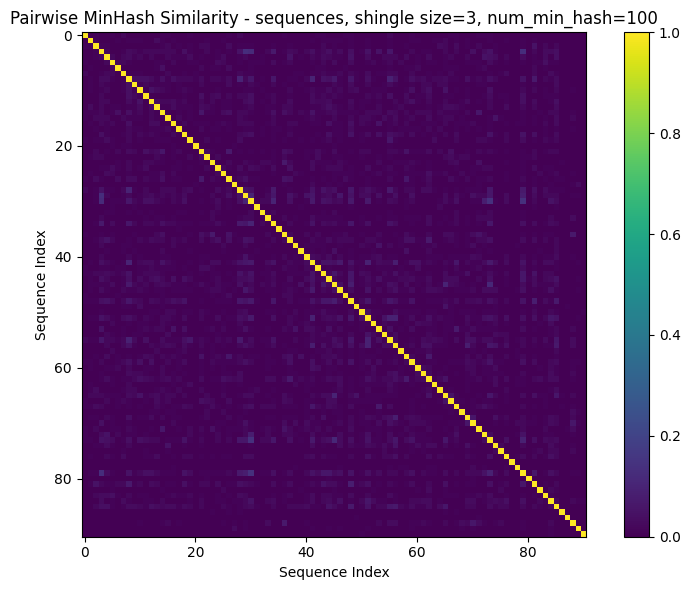

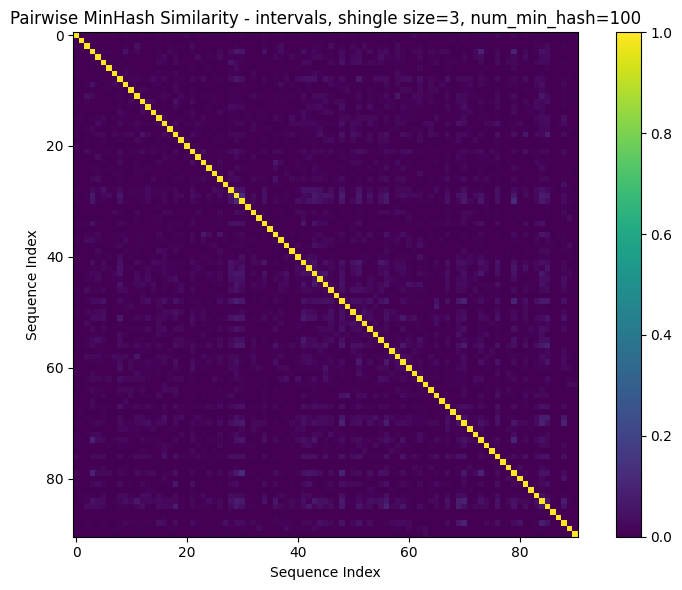

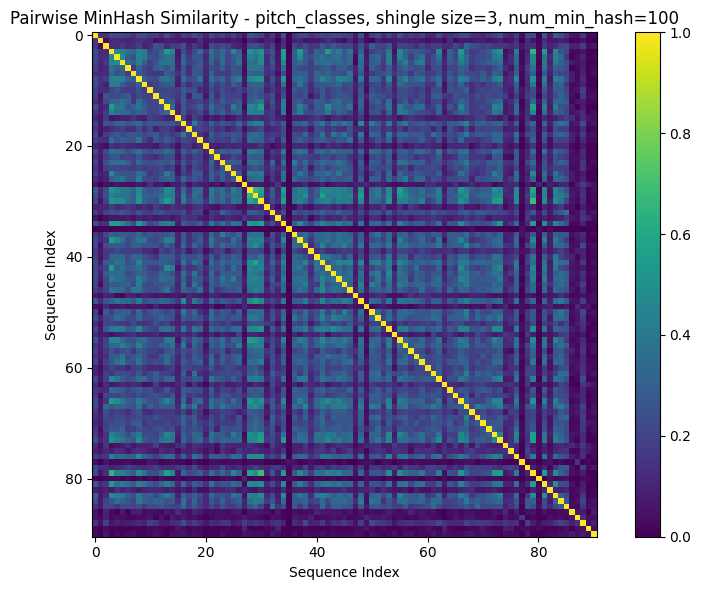

In [10]:
test_minhash(
    shingle_size=3,
    num_minhash=100
)